In [1]:
#import required packages
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr  #calculate the Pearson's correlation between two variables
from scipy.stats import kurtosis, kurtosistest #test the 'tailedness' of probability distribution of variable
from scipy.stats import skew, skewtest #test the skewness of distribution of variables
import datetime
from datetime import datetime
import calendar
import matplotlib.dates as mdates
import statistics
import pylab
from itertools import chain
from statsmodels.tsa.seasonal import seasonal_decompose

#sklearn package for modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor #check VIF score for multicollinearity detection

#visualization package
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Create feature matrix with Patsy and StatsModels
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
#Display 100 rows at maximum
pd.set_option('display.max_rows', 100)

#read csv into dataframe
listings = pd.read_csv('listings.csv')

print('We have {} properties in the listing dataset, containing {} features.'.format(listings['id'].nunique(), listings.shape[1]))

We have 11248 properties in the listing dataset, containing 109 features.


C:\Users\komin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (68,69,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# (1) Removing irrelevant and redundant columns

In [3]:
#Drop freeform text, url and scraping identifier columns
irrelevant_cols = ['listing_url', 'scrape_id', 'name', 'summary', 'space',
                   'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access',
                   'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_location',
                   'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'calendar_updated', 'calendar_last_scraped']

#Drop legal-related columns
legal_cols = ['requires_license', 'license', 'jurisdiction_names']

#Drop host details columns
host_cols = ['host_neighbourhood', 'host_verifications','host_total_listings_count', 'calculated_host_listings_count',
             'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']

#Drop redundant columns related to listings
listings_redundant_cols = ['street', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country']

listings.drop(irrelevant_cols+legal_cols+host_cols+listings_redundant_cols, axis=1, inplace=True)

### Given that multiple columns describes minimum and maximum night stays, we only keep two of them ('minimum_nights' and 'maximum_nights') to avoid data redundancy

In [4]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
               'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

### Remove columns with more than 50% missing values

In [5]:
#Check columns in which more than half of them are missing values
missing_value_portion = listings.isnull().sum() / len(listings)
missing_more_than_half_cols = listings.columns[missing_value_portion > 0.5]
print(list(missing_more_than_half_cols))

#Remove these columns
listings.drop(missing_more_than_half_cols, axis=1, inplace=True)

['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price']


# (2) Imputing missing data, binning variables and creating new variables

### Imputing columns with more than 25% missing values

In [6]:
missing_value_portion = listings.isnull().sum() / len(listings)
imputing_cols = listings.columns[missing_value_portion > 0.25]

for i in imputing_cols:
    print(i + '  ' + str(round(missing_value_portion[i],3)))

security_deposit  0.444
cleaning_fee  0.365
reviews_per_month  0.284
first_review  0.284
last_review  0.284
review_scores_rating  0.299
review_scores_accuracy  0.299
review_scores_cleanliness  0.299
review_scores_checkin  0.299
review_scores_communication  0.299
review_scores_location  0.299
review_scores_value  0.299


### Missing value for security deposit/cleaning fee implies the amount is equal to zero, so missing values will be replaced with 0.

In [7]:
#1.Security deposit
listings[['security_deposit']] = listings['security_deposit'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))
listings['security_deposit'].fillna(0, inplace=True)

#2.Cleaning fee
listings[['cleaning_fee']] = listings['cleaning_fee'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))
listings['cleaning_fee'].fillna(0, inplace=True)

### Instead of mean imputation, missing value for 'bathrooms','bedrooms' and 'beds' will be replaced with the median so as to avoid fractions.

In [8]:
for cols in ['bathrooms', 'bedrooms', 'beds']:
    listings[cols].fillna(listings[cols].median(), inplace=True)

### About 30% of listings do not have any reviews. It is not good practice to drop such a large proportion or simply replace with median/mean values, and dropping the columns (e.g. 'review_per_month', 'review_scores_ratings') would result in losing useful information for booking decision.

### In fact, NaN implies that these are new or previously unbooked listings. Review features can be treated as categorical by binning review scores. 

In [9]:
#First review
#Converting data type to datetime
listings['first_review'] = pd.to_datetime(listings['first_review'])

#Calculating the number of days between the first review and the date of scraping data
listings['time_since_first_review'] = (pd.to_datetime(listings['last_scraped']) - listings['first_review']).astype('timedelta64[D]')

def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces null ('nan'->'unknown' if unspecified).
    """
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].replace('nan',na_label, inplace=True)

In [10]:
#Binning 'time since first review'
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings['time_since_first_review'])],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

#Category counts
listings['time_since_first_review'].value_counts()

no reviews     3286
2-3 years      2530
1-2 years      2135
6-12 months    1520
4+ years        996
0-6 months      781
Name: time_since_first_review, dtype: int64

In [11]:
#last review
#Converting data type to datetime
listings['last_review'] = pd.to_datetime(listings['last_review'])

#Calculating the number of days between the last review and the date of scraping data
listings['time_since_last_review'] = (pd.to_datetime(listings['last_scraped']) - listings['last_review']).astype('timedelta64[D]')

In [12]:
#Binning 'time since last review'
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listings['time_since_last_review'])],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

#Category counts
listings['time_since_last_review'].value_counts()

no reviews     3449
2-6 months     3362
6-12 months    2213
1+ year        1851
2-8 weeks       266
0-2 weeks       107
Name: time_since_last_review, dtype: int64

In [13]:
#Dropping last_review
listings.drop('last_review', axis=1, inplace=True)

In [14]:
#Binning 'review_scores_rating'
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79', '80-94', '95-100'],
           na_label='no reviews')

# Category counts
listings['review_scores_rating'].value_counts()

80-94         3766
no reviews    3362
95-100        3163
0-79           957
Name: review_scores_rating, dtype: int64

In [15]:
# Binning for all remaining 'review score' columns
for cols in ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
             'review_scores_communication','review_scores_location','review_scores_value']:
    
    bin_column(cols,
               bins=[0, 8, 9, 10],
               labels=['0-8', '9', '10'],
               na_label='no reviews')

### Convert data to correct types

In [16]:
#Convert to float
#Remove commas and dollars signs
listings[['price']] = listings['price'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))
listings[['extra_people']] = listings['extra_people'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))

In [17]:
#Convert T/F to boolean (0 vs 1)
listings = listings.replace(to_replace=['t', 'f', 'nan'], value=[1, 0, np.nan])

In [18]:
#Convert float to string
listings["host_response_time"] = listings['host_response_time'].astype(str)

### Drop boolean attributes with highly skewed category distribution

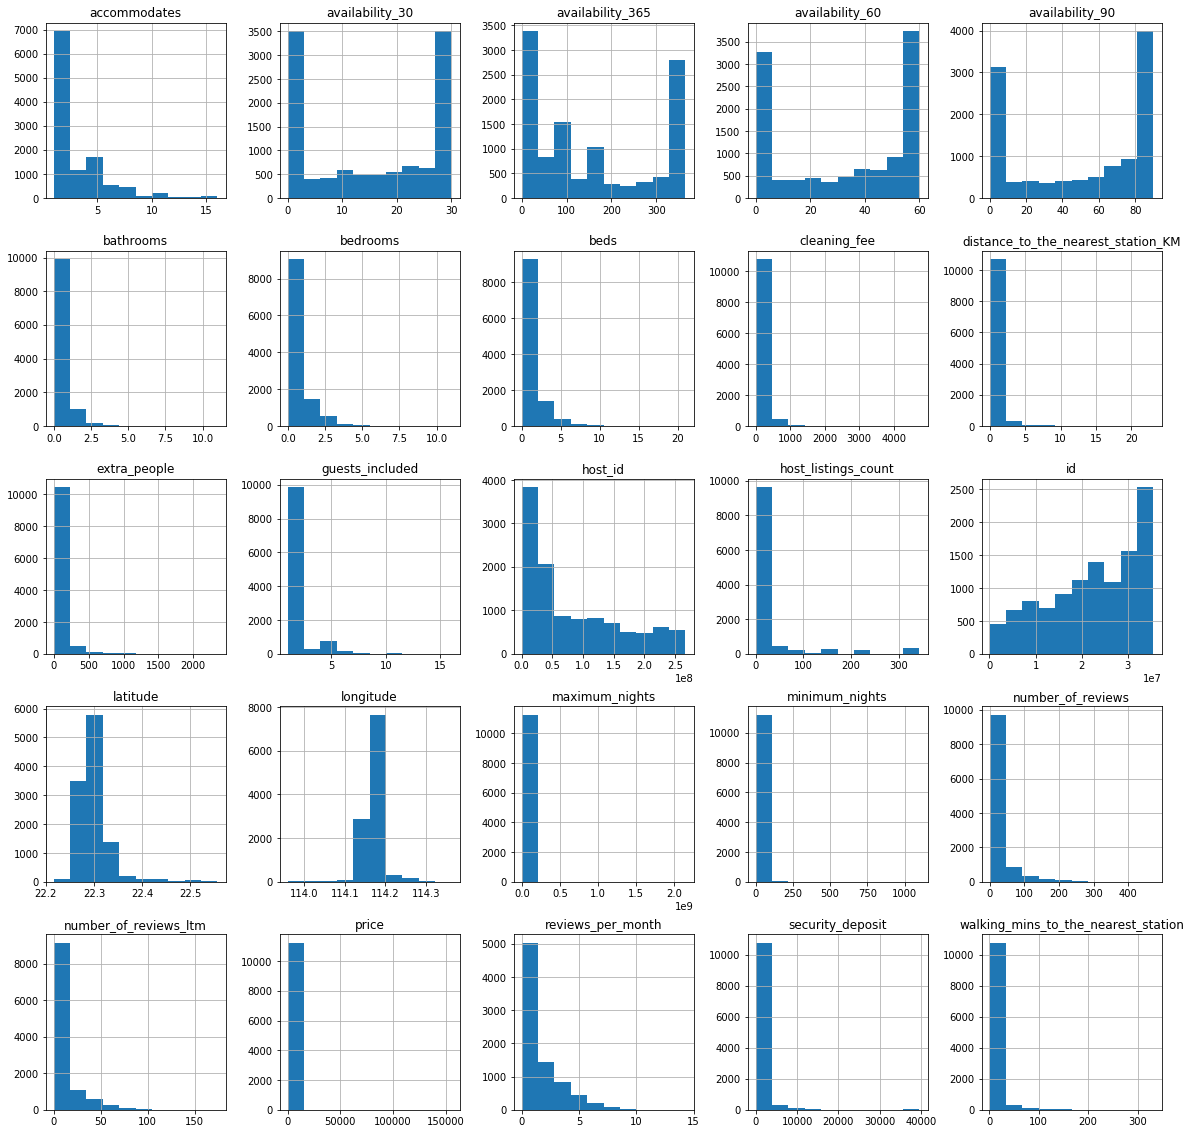

In [19]:
#Plotting histograms to check distribution of numeric and boolean variables
listings.hist(figsize=(20,20));

In [20]:
#Drop boolean columns with single category
listings.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture'], axis=1, inplace=True)

### Remove 'neighbourhood' column as it is only extension of 'neighbourhood_cleansed' column which contains sparse districts in Hong Kong

In [21]:
#listings['neighbourhood'].value_counts()
listings.drop('neighbourhood', axis=1, inplace=True)

### Remove 'number_of_reviews_ltm' and 'reviews_per_month' as they are highly correlated with number_of_reviews 

In [22]:
listings.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

### Remove listing with advertised price equal to 0

In [23]:
print(str(len(listings[listings['price'] == 0])) +' listings with zero advertised price will be removed.')
listings = listings[listings['price'] != 0]

5 listings with zero advertised price will be removed.


### Grouping missing value into "unknown"category for 'host_response_time'

In [24]:
listings[['host_response_time']] = listings['host_response_time'].apply(lambda x: str(x).replace("nan", "unknown"))
listings['host_response_time'].value_counts(normalize=True)

within an hour        0.527528
unknown               0.211065
within a few hours    0.157876
within a day          0.086098
a few days or more    0.017433
Name: host_response_time, dtype: float64

### Binning 'host_response_rate' into four groups

In [25]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].replace(regex=["%"], value=""), errors='coerce')

#Binning into four groups
binning_labels = ['0-49%', '50-89%', '90-99%', '100%']
category = [0, 50, 90, 99, 100]
listings['host_response_rate'] = pd.cut(listings['host_response_rate'], labels = binning_labels, bins = category, include_lowest=True)

# Converting to string
listings['host_response_rate'] = listings['host_response_rate'].astype('str')

# Replace nulls with 'unknown'
listings['host_response_rate'].replace('nan', 'unknown', inplace=True)

# Category counts
listings['host_response_rate'].value_counts()

100%       5889
unknown    2373
90-99%     1406
50-89%     1226
0-49%       349
Name: host_response_rate, dtype: int64

### Create calculated field 'host_duration' to measure duration of the host lifetime on Airbnb.

In [26]:
#Drop listings without values of 'host_since' (n=7)
listings.dropna(subset=['host_since'], inplace=True)

#Convert data to correct type (datetime)
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'], format='%d/%m/%Y')
listings['host_since'] = pd.to_datetime(listings['host_since'], format='%d/%m/%Y')

#Create new variable 'host listed days' to calculate the number of days between host join date and listing last seen date
listings['host_duration_days'] = (listings['last_scraped'] - listings['host_since']).dt.days

#Keep 'host_since' for EDA while dropping 'last_scraped' column as it is no longer useful
listings.drop(['last_scraped'], axis=1, inplace=True)

### Create calculated field 'price_per_person' to measure advertised price per person

In [27]:
listings['price_per_person'] = (listings['price'] / listings['accommodates']).astype('int64')

### Grouping sparse property types into three main categories: Apartment/ House/ Other

In [28]:
#listings['property_type'].value_counts()

#Regrouping categories into houses, apartments or others
listings['property_type'].replace({
    'Condominium': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Aparthotel': 'Apartment',
    'Loft': 'Apartment',
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
    }, inplace=True)

#Group other categories with 'Other'
listings.loc[~listings['property_type'].isin(['House', 'Apartment']), 'property_type'] = 'Other'

### Grouping minor cancellation policies into three main categories

In [29]:
listings['cancellation_policy'].value_counts()

strict_14_with_grace_period    6354
flexible                       3152
moderate                       1692
super_strict_60                  22
super_strict_30                  14
strict                            2
Name: cancellation_policy, dtype: int64

In [30]:
# Replacing categories
listings['cancellation_policy'].replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    }, inplace=True)

# (3) Data cleansing for amenities

### Amenities is a list of additional features in the property. Given that some amenities are more important than others (e.g. wifi is more likely to increase price than a oven), this feature will not be useful to explain differences in prices if all amenities are included (no matter how important they are).

In [31]:
# Creating a set of all possible amenities
amenities = listings["amenities"].str.split(",",expand=True)
amenities = amenities.replace(regex=["[^\w\s]"], value="")
amenities_list = [amenities[item].unique().tolist() for item in amenities.columns.values]
amenities_list = set(list(chain.from_iterable(amenities_list)))
amenities_list.remove('')
amenities_list.remove(None)
amenities_list

{' toilet',
 '24hour checkin',
 'Accessibleheight bed',
 'Accessibleheight toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Building staff',
 'Buzzerwireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cats',
 'Ceiling hoist',
 'Changing table',
 'Childrenâs books and toys',
 'Childrenâs dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dogs',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Extra space around shower and toilet',
 'Familykid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed 

In [32]:
print("Total amenities: " + str(len(amenities_list)))

Total amenities: 127


### Encode amenities as dummy variables

In [33]:
for items in amenities_list:
    listings[items] = listings["amenities"].apply(lambda x: 1 if items in x else 0)

### Remove the amenities which contains in less than 10% of listings

In [34]:
# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []

for col in listings.iloc[:,48:].columns:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
listings.drop(infrequent_amenities, axis=1, inplace=True)

['Crib', 'Firm mattress', 'BBQ grill', 'Stair gates', ' toilet', 'Lake access', 'Game console', 'Wide entrance for guests', 'Bathtub with bath chair', 'Smart lock', 'Extra space around shower and toilet', 'Familykid friendly', 'Wide hallways', 'Shower chair', 'EV charger', 'High chair', 'Babysitter recommendations', 'SkiinSkiout', 'translation missing enhosting_amenity_50', 'Lockbox', 'Ethernet connection', 'Fixed grab bars for shower', 'Safety card', 'Disabled parking spot', 'Window guards', 'Pool with pool hoist', 'Rollin shower', 'Other', 'No stairs or steps to enter', 'Paid parking on premises', 'Pocket wifi', 'Private bathroom', 'translation missing enhosting_amenity_49', 'Fixed grab bars for toilet', 'Roomdarkening shades', 'Free parking on premises', 'Hot tub', 'Wide entryway', 'Pool', 'Indoor fireplace', 'Pets live on this property', 'Patio or balcony', 'Ground floor access', 'Free street parking', 'Accessibleheight toilet', 'Wide doorway to guest bathroom', 'Private living roo

In [35]:
#count of finally selected amenities
len(amenities_list) - len(infrequent_amenities)

34

### Out of 127 amenities features, we finally keep 34 of them only.

In [36]:
#Overview of listings
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11236 entries, 0 to 11247
Data columns (total 83 columns):
id                                     11236 non-null int64
latitude                               11236 non-null float64
longitude                              11236 non-null float64
host_id                                11236 non-null int64
host_since                             11236 non-null datetime64[ns]
host_response_time                     11236 non-null object
host_response_rate                     11236 non-null object
host_is_superhost                      11236 non-null object
host_listings_count                    11236 non-null float64
host_identity_verified                 11236 non-null object
neighbourhood_cleansed                 11236 non-null object
is_location_exact                      11236 non-null object
nearest_mtr_station                    11236 non-null object
distance_to_the_nearest_station_KM     11236 non-null float64
walking_mins_to_the_nearest

## Finally, we have 11236 listings with 83 features (in which 34 of them are amenity features).

# (4) Data cleansing for 'calendar.csv'

The goal of this part is to clean the calendar dataset so as to run price seasonality analysis.

In [37]:
calendar_df = pd.read_csv("calendar.csv.gz")

In [38]:
print('We have', calendar_df.date.nunique(), 'days and', calendar_df.listing_id.nunique(), 'unique listings in the calendar data.')

We have 365 days and 12107 unique listings in the calendar data.


In [39]:
listings_id = list(listings['id'])
calendar_list = list(dict.fromkeys(calendar_df['listing_id']))
drop_listings = []

#List of listings not found in final listing list
for list_c in calendar_list:
    if list_c not in listings_id:
        drop_listings.append(list_c)

In [40]:
calendar_df = calendar_df[~calendar_df['listing_id'].isin(drop_listings)]

print('After removing', len(drop_listings), 'listings not exist in the cleansed "listing" dataframe, now we have', calendar_df.date.nunique(), 'days and', calendar_df.listing_id.nunique(), 'unique listings in the calendar data.')

After removing 871 listings not exist in the cleansed "listing" dataframe, now we have 365 days and 11236 unique listings in the calendar data.


In [41]:
#Remove special characters ('$',',') and then convert price column to float
calendar_df.price = calendar_df.price.str.lstrip('$').str.replace(',', '')
calendar_df.price = calendar_df.price.astype('float')

#Convert string date to datetime object
calendar_df.date = pd.to_datetime(calendar_df.date)

In [42]:
#Overview of calendar
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4101140 entries, 0 to 4414310
Data columns (total 7 columns):
listing_id        int64
date              datetime64[ns]
available         object
price             float64
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 250.3+ MB


In [43]:
#Export cleansed listings datasets
calendar_df.to_csv('calendar(cleansed)' + '.csv.gz', index = False, compression='gzip')

# (5) Exploring Venues per Neighborhood (District) in Hong Kong

In [44]:
#required module for neighbourhood analysis
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests
import descartes

### We will use Foursquare API to explore Top 10 popular places around each neighbourhood.
### The query parameters include but not limited to:
- CLIENT_ID - API credential
- CLIENT_SECRET - API credential
- Versioning (V) - date in YYYYMMDD format that lets you tell Foursquare “I’m prepared for API changes up to this date.”
- Latitude & Longitude (ll) - Latitude and longitude of the user’s location
- radius - Radius to search within, in meters
- limit - Number of results to return
- sortByPopularity - Boolean flag to sort the results by popularity instead of relevance
#### Reference: https://developer.foursquare.com/docs/api/venues/explore

In [45]:
#Define Foursquare Credentials for using Places API
CLIENT_ID = 'IPLFC1Q3JHFPVACJXA0GXDLTODWZ5BBSOHSQNLBS1J51FSZB'
CLIENT_SECRET = 'QDVWCJR433MXM3ZUFQNACNASB2NMZHIWMQZXTXJHO3WYELY1'

version = '20190610'
radius = 1000
limit = 10
sortByPopularity = 1

Although GeoJSON file of neighbourhoods (18 districts) of the city is available on InsideAirbnb, some coordinates derived from the centroid of district boundaries are hard for us to find 'meaningful' proximity venues near the district. In view of avoiding proximity venue misinterpretation, I scratched the coordinates for each districts on latitude.to and save it in 'hk_districts_coordinates.csv' for the following neighbourhood analysis.

In [46]:
#Importing coordinates of 18 districts in hk 
map_df = pd.read_csv('hk_districts_coordinates.csv')
map_df.head()

,district,latitude,longitude
0,Central & Western,22.2833,114.1500
1,Yau Tsim Mong,22.3116,114.1707
2,Yuen Long,22.4446,114.0222
3,Wan Chai,22.2763,114.1826
4,Southern,22.2432,114.1974


In [47]:
# Function to loop for venues through all neighbourhoods
def exploreNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            version,
            lat, 
            lng, 
            radius,
            limit,
            sortByPopularity)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Run the above function to call Foursquare API.

In [48]:
district_venues = exploreNearbyVenues(names=map_df['district'],
                                      latitudes=map_df['latitude'],
                                      longitudes=map_df['longitude']
                                      )

print('The result returns {} venues with {} unique categories for {} districts.'.format(len(district_venues['Venue'].unique()),
                                                                                        len(district_venues['Venue Category'].unique()),
                                                                                        len(district_venues['Neighbourhood'].unique())))

district_venues.head()

The result returns 152 venues with 61 unique categories for 18 districts.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central & Western,22.2833,114.15,ifc mall (國際金融中心商場),22.284613,114.158156,Shopping Mall
1,Central & Western,22.2833,114.15,Tai Kwun Centre for Heritage and Arts (大館古蹟及藝術館),22.281224,114.154032,Art Museum
2,Central & Western,22.2833,114.15,Apple ifc mall,22.284602,114.159072,Electronics Store
3,Central & Western,22.2833,114.15,city'super,22.286319,114.157806,Supermarket
4,Central & Western,22.2833,114.15,Pure Fitness,22.285137,114.159455,Gym / Fitness Center


In [49]:
#Count venue collected for each neighbourhood:
district_venues[['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(['Venue'], ascending=True)

,Venue
Neighbourhood,
Islands,2
North,4
Central & Western,10
Wong Tai Sin,10
Wan Chai,10
Tuen Mun,10
Tsuen Wan,10
Tai Po,10
Southern,10


Even though the Place API search quota is set up to 10 places within 1KM of pre-defined coordinates, the API only returns 2 venues for Islands and North Districts respectively.

From guests perspective, it is believed that level of proximity to 'hotel' does not matter when thinking about the convenience of location. We can therefore remove "Hotel" from the the venue list. 

In [50]:
district_venues.drop(district_venues.loc[district_venues['Venue Category']=='Hotel'].index, inplace=True)
district_venues.reset_index(drop=True)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central & Western,22.28330,114.15000,ifc mall (國際金融中心商場),22.284613,114.158156,Shopping Mall
1,Central & Western,22.28330,114.15000,Tai Kwun Centre for Heritage and Arts (大館古蹟及藝術館),22.281224,114.154032,Art Museum
2,Central & Western,22.28330,114.15000,Apple ifc mall,22.284602,114.159072,Electronics Store
3,Central & Western,22.28330,114.15000,city'super,22.286319,114.157806,Supermarket
4,Central & Western,22.28330,114.15000,Pure Fitness,22.285137,114.159455,Gym / Fitness Center
...,...,...,...,...,...,...,...
153,Kwun Tong,22.31570,114.23310,YATA Supermarket (一田超市),22.312588,114.224999,Supermarket
154,Kwun Tong,22.31570,114.23310,Sau Mau Ping Shopping Centre (秀茂坪商場),22.319338,114.231681,Shopping Mall
155,Kwun Tong,22.31570,114.23310,Palace APM (百老匯院線),22.312220,114.225283,Multiplex
156,Islands,22.26279,113.96554,Lantau Mountain Camp (爛頭營),22.258358,113.960033,Mountain


In [51]:
#district_venues['Venue Category'].value_counts()

Besides, there are dozens of sub-categories of restuarant (e.g. bar, buffet, Fast Food Restaurant) in return. It is better to group them all into one single category named "Restaurant"

In [52]:
restaurant_subgroup = list(district_venues.loc[district_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'].unique())
restaurant_subgroup += ['Cha Chaan Teng','Fried Chicken Joint','Burger Joint','Pizza Place', 'Bar', 'Noodle House']

In [53]:
#Group all resturant-related subcategories together under "Restaurant"
district_venues['Venue Category'].replace(to_replace = restaurant_subgroup,
                                          value = 'Restaurant', 
                                          inplace = True)

For easy understanding, let's rename 'Multiplex' as 'Movie Theater' as well.

In [54]:
district_venues['Venue Category'].replace('Multiplex', 'Movie Theater', inplace = True)

Lastly, concatenate Venue Latitude and Longitude into one string for the convenience of using Google Map API

In [55]:
district_venues['Venue LatLng'] = round(district_venues['Venue Latitude'],6).astype(str) + ',' + round(district_venues['Venue Longitude'],6).astype(str)

In [56]:
#Export dataframe district_venues to csv
district_venues.to_csv('district_popular_venues' + '.csv', index = False, encoding = 'utf-8-sig')

## What is the categories for the top 3 most popular venue?

First, rank the popularity of venue category by district:

In [57]:
sorted_district_venues = district_venues.groupby('Neighbourhood')['Venue Category'].apply(lambda district_venues: district_venues.reset_index(drop=True)).unstack();

In [58]:
def rename_column(df, selected_columns):

    #rename column to make it easy to understand (e.g. '1st most popular venue', '2nd most popular venue'...)
    re_col = []

    for i in selected_columns:
        if i == 0:
            re_col.append(str(i+1) + 'st most popular venue')
        
        elif i == 1:
            re_col.append(str(i+1) + 'nd most popular venue')
    
        elif i == 2:
            re_col.append(str(i+1) + 'rd most popular venue')
        
        else:
            re_col.append(str(i+1) + 'th most popular venue')
        
    df.columns = [re_col]
    df.reset_index(inplace=True)

rename_column(sorted_district_venues, sorted_district_venues.columns.values)

In [59]:
#Do the same for sorted venue coordinate group by neighbourhood
popular_venues_coordinates = district_venues.groupby('Neighbourhood')['Venue LatLng'].apply(lambda district_venues: district_venues.reset_index(drop=True)).unstack()

#run the function to rename columns in 'popular_venues_coordinates'
rename_column(popular_venues_coordinates, popular_venues_coordinates.columns.values)

In [60]:
#For analysis in next topic -- Measurement of walkability for each listing
sorted_district_venues.to_csv('sorted_district_venues' + '.csv', index = False, encoding = 'utf-8-sig')
popular_venues_coordinates.to_csv('sorted_district_venues_coordinate' + '.csv', index = False, encoding = 'utf-8-sig')

sorted_district_venues = pd.read_csv('sorted_district_venues.csv')
sorted_district_venues

,Neighbourhood,1st most popular venue,2nd most popular venue,3rd most popular venue,4th most popular venue,5th most popular venue,6th most popular venue,7th most popular venue,8th most popular venue,9th most popular venue,10th most popular venue
0,Central & Western,Shopping Mall,Art Museum,Electronics Store,Supermarket,Gym / Fitness Center,Coffee Shop,Movie Theater,Coffee Shop,NaN,NaN
1,Eastern,Shoe Store,Farmers Market,Coffee Shop,Restaurant,Restaurant,Dessert Shop,Snack Place,Restaurant,Restaurant,History Museum
2,Islands,Mountain,Scenic Lookout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kowloon City,Shopping Mall,Shopping Mall,Park,Market,Restaurant,Playground,Café,Restaurant,Coffee Shop,NaN
4,Kwai Tsing,Metro Station,Shopping Mall,Restaurant,Theater,Gift Shop,Restaurant,Restaurant,Movie Theater,Grocery Store,Dance Studio
5,Kwun Tong,Shopping Mall,Building,Restaurant,Electronics Store,Restaurant,Restaurant,Restaurant,Supermarket,Shopping Mall,Movie Theater
6,North,Restaurant,Other Great Outdoors,Playground,Bakery,NaN,NaN,NaN,NaN,NaN,NaN
7,Sai Kung,Pier,Park,Restaurant,Bus Station,Restaurant,Restaurant,Dessert Shop,Restaurant,Bowling Alley,Coffee Shop
8,Sha Tin,Shopping Mall,Shopping Mall,Train Station,Train Station,Bus Station,River,Restaurant,Restaurant,Buffet,NaN
9,Sham Shui Po,Platform,Shopping Mall,Restaurant,Department Store,Coffee Shop,Park,Bus Station,Restaurant,Athletics & Sports,Restaurant


In [61]:
print('The Top 3 most popular venue category across HK districts are {},{} and {}.'.format(sorted_district_venues['1st most popular venue'].mode().iloc[0],
                                                                                           sorted_district_venues['2nd most popular venue'].mode().iloc[0],
                                                                                           sorted_district_venues['3rd most popular venue'].mode().iloc[0]))

The Top 3 most popular venue category across HK districts are Shopping Mall,Shopping Mall and Shopping Mall.


### No wonder Hong Kong is charactacterised as a shopping paradise for many tourists. As you can see, the result shows that the top 3 most popular venues among districts are both 'Shopping Mall'.  Apart from shopping, it makes sense to see people are more likely to look for other venues in some other places such as beach and pier in Southern and Sai Kung District respectively.

# (6) Measurement of walkability score per listing within the neighbourhood

Criteria:
- Proximity of railway (the Nearest MTR station)
- Accessibility of the top 5 most popular venues (Point-of-interest, aka 'POI') in the neighbourbood (POI was retrieved from Foursquare API)

In [62]:
listings.head()

,id,latitude,longitude,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,...,Smoke detector,Fire extinguisher,Cooking basics,Wifi,Dryer,Bed linens,Luggage dropoff allowed,First aid kit,Kitchen,Cable TV
0,69074,22.28352,114.15018,160139,2010-07-07,within an hour,100%,1,2.0,1,...,1,0,0,1,1,0,0,1,1,1
1,103760,22.28407,114.15570,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,...,0,0,0,1,0,0,0,0,1,1
2,132773,22.28868,114.14494,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,...,0,0,0,1,0,0,0,0,1,1
3,133390,22.28343,114.15539,654642,2011-06-02,within a day,100%,0,1.0,1,...,1,0,0,1,0,0,0,0,1,1
4,163214,22.28494,114.15251,767910,2011-07-01,unknown,unknown,0,0.0,1,...,0,0,1,1,0,0,0,0,1,1


In [63]:
#Create new df and extract listing id and neighbourhood from listing df only
listing_neighbourhood = listings[['id','latitude', 'longitude', 'neighbourhood_cleansed']]

In [64]:
#Concatenate Latitude and Longitude into one single variable
listing_neighbourhood['origin_coordinate'] = round(listings['latitude'],5).astype(str) + ',' + round(listings['longitude'],5).astype(str)
listing_neighbourhood.drop(['latitude','longitude'], axis=1, inplace=True)
listing_neighbourhood.rename(columns={'neighbourhood_cleansed':'Neighbourhood'}, inplace=True)
listing_neighbourhood.head()

C:\Users\komin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\komin\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\komin\Anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

,id,Neighbourhood,origin_coordinate
0,69074,Central & Western,"22.28352,114.15018"
1,103760,Central & Western,"22.28407,114.1557"
2,132773,Central & Western,"22.28868,114.14494"
3,133390,Central & Western,"22.28343,114.15539"
4,163214,Central & Western,"22.28494,114.15251"


In [65]:
#select the top 5 most popular venue per neighbourhood
sorted_district_venues_coordinate = pd.read_csv('sorted_district_venues_coordinate.csv')
sorted_district_venues_coordinate = sorted_district_venues_coordinate.iloc[:, list(range(6))]

In [66]:
#Using 'Neighbourhood' as key, map the top 5 most popular venue to listing id 
listing_neighbourhood = pd.merge(listing_neighbourhood, sorted_district_venues_coordinate, on='Neighbourhood')
listing_neighbourhood.head()

,id,Neighbourhood,origin_coordinate,1st most popular venue,2nd most popular venue,3rd most popular venue,4th most popular venue,5th most popular venue
0,69074,Central & Western,"22.28352,114.15018","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
1,103760,Central & Western,"22.28407,114.1557","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
2,132773,Central & Western,"22.28868,114.14494","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
3,133390,Central & Western,"22.28343,114.15539","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
4,163214,Central & Western,"22.28494,114.15251","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"


In [67]:
#Create dataframe to capture listing id, origin coordinate and venue coordinate for each row
df_merged = pd.DataFrame(columns=['id', 'neighbourhood', 'origin_coordinate', 'venue_coordinate', 'remarks'])

for i in range(3,8): 
    temp = pd.DataFrame({'id': list(listing_neighbourhood['id']),
                         'neighbourhood': list(listing_neighbourhood['Neighbourhood']),
                         'origin_coordinate': list(listing_neighbourhood['origin_coordinate']),
                         'venue_coordinate': list(listing_neighbourhood[listing_neighbourhood.columns[i]]),
                         'remarks': listing_neighbourhood.columns[i]
                        })
    
    df_merged = pd.concat([df_merged, temp])
    
df_merged

,id,neighbourhood,origin_coordinate,venue_coordinate,remarks
0,69074,Central & Western,"22.28352,114.15018","22.284613,114.158156",1st most popular venue
1,103760,Central & Western,"22.28407,114.1557","22.284613,114.158156",1st most popular venue
2,132773,Central & Western,"22.28868,114.14494","22.284613,114.158156",1st most popular venue
3,133390,Central & Western,"22.28343,114.15539","22.284613,114.158156",1st most popular venue
4,163214,Central & Western,"22.28494,114.15251","22.284613,114.158156",1st most popular venue
...,...,...,...,...,...
11231,34296432,Kwun Tong,"22.30767,114.21679","22.312709,114.225232",5th most popular venue
11232,34296991,Kwun Tong,"22.30927,114.22042","22.312709,114.225232",5th most popular venue
11233,34487935,Kwun Tong,"22.30928,114.22049","22.312709,114.225232",5th most popular venue
11234,34613665,Kwun Tong,"22.31776,114.23415","22.312709,114.225232",5th most popular venue


In [68]:
df_merged.to_csv('listing_proximity_venues_coordinates' + '.csv', index = False, encoding = 'utf-8-sig')

### After getting walking distance and time for each pair of origins and destinations using Google Map Distance Matrix API, the next step is to calculate walking score for each listing.

In [69]:
listing_proximity_venues_coordinates_final = pd.read_csv('listing_proximity_venues_coordinates(combined).csv')
listing_proximity_venues_coordinates_final.head()

,ListingID,Neighbourhood,Origin,Destination,remarks,Distance,Walking time (mins)
0,69074,Central & Western,"22.28352,114.15018","22.284613,114.158156",1st most popular venue,1.5 km,20.0
1,103760,Central & Western,"22.28407,114.1557","22.284613,114.158156",1st most popular venue,0.8 km,11.0
2,132773,Central & Western,"22.28868,114.14494","22.284613,114.158156",1st most popular venue,1.9 km,26.0
3,133390,Central & Western,"22.28343,114.15539","22.284613,114.158156",1st most popular venue,0.8 km,11.0
4,163214,Central & Western,"22.28494,114.15251","22.284613,114.158156",1st most popular venue,1.2 km,16.0


In [70]:
#Calculate average walking time to proximity venue group by listing id
listing_avg_walking_time = listing_proximity_venues_coordinates_final.groupby('ListingID')['Walking time (mins)'].mean().to_frame()
listing_avg_walking_time.reset_index(inplace=True)

In [71]:
#Drop (20) listings without values of ''Walking time (mins)'...most likely those were located near boundary areas or unaccessible to proximity venues by walking
listing_avg_walking_time.dropna(subset=['Walking time (mins)'], inplace=True)

In [72]:
#Retain unique 'ListingID' with 'Neighbourhood' fields only in 'listing_proximity_venues_coordinates_final'
listing_proximity_venues_coordinates_final = listing_proximity_venues_coordinates_final[['ListingID','Neighbourhood']].drop_duplicates('ListingID')
listing_proximity_venues_coordinates_final

,ListingID,Neighbourhood
0,69074,Central & Western
1,103760,Central & Western
2,132773,Central & Western
3,133390,Central & Western
4,163214,Central & Western
...,...,...
11231,34296432,Kwun Tong
11232,34296991,Kwun Tong
11233,34487935,Kwun Tong
11234,34613665,Kwun Tong


In [73]:
#Normalize listing venue walkability (range is set between 0-100)
listing_venues_walkability = listing_proximity_venues_coordinates_final.merge(listing_avg_walking_time, on='ListingID', how = 'inner')

scaler = MinMaxScaler(feature_range=(0, 100))  #Create the Scaler object
listing_venues_walkability['normalized_walkability_score'] = scaler.fit_transform(listing_venues_walkability['Walking time (mins)'].values.reshape(-1,1))

listing_venues_walkability.rename(columns = {'ListingID':'id', 'Walking time (mins)':'avg_walking_mins_to_top5_neighhourhood_venues'}, inplace = True)

In [74]:
listing_venues_walkability = listing_venues_walkability[['id', 'avg_walking_mins_to_top5_neighhourhood_venues', 'normalized_walkability_score']]
listings_final = listings.merge(listing_venues_walkability, on='id', how = 'inner')
listings_final

,id,latitude,longitude,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,...,Cooking basics,Wifi,Dryer,Bed linens,Luggage dropoff allowed,First aid kit,Kitchen,Cable TV,avg_walking_mins_to_top5_neighhourhood_venues,normalized_walkability_score
0,69074,22.28352,114.15018,160139,2010-07-07,within an hour,100%,1,2.0,1,...,0,1,1,0,0,1,1,1,17.6,2.977867
1,103760,22.28407,114.15570,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,...,0,1,0,0,0,0,1,1,11.2,1.690141
2,132773,22.28868,114.14494,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,...,0,1,0,0,0,0,1,1,23.6,4.185111
3,133390,22.28343,114.15539,654642,2011-06-02,within a day,100%,0,1.0,1,...,0,1,0,0,0,0,1,1,10.8,1.609658
4,163214,22.28494,114.15251,767910,2011-07-01,unknown,unknown,0,0.0,1,...,1,1,0,0,0,0,1,1,14.4,2.334004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11211,35533995,22.28577,114.13647,267338654,2019-06-09,unknown,unknown,0,1.0,0,...,0,1,0,0,0,0,0,0,34.8,6.438632
11212,35535086,22.25766,114.19155,7518056,2013-07-16,within a few hours,90-99%,0,343.0,0,...,0,1,0,0,0,0,1,0,47.0,8.893360
11213,35535699,22.25766,114.19155,7518056,2013-07-16,within a few hours,90-99%,0,343.0,0,...,0,1,0,0,0,0,1,0,47.0,8.893360
11214,35535839,22.25766,114.19155,7518056,2013-07-16,within a few hours,90-99%,0,343.0,0,...,0,1,0,0,0,0,1,0,47.0,8.893360


In [75]:
#Export cleansed listings datasets
#listings_final.to_csv('listings(cleansed)' + '.csv', index = False)

# (7) Exploratory Data Analysis (EDA)

In [76]:
print("For Airbnb hosts that were still listing on Airbnb as of 2019-06-10, the first host had joined since {}, and the most recent one since {}.".format(min(listings_final.host_since).strftime('%Y-%m-%d'),max(listings_final.host_since).strftime('%Y-%m-%d')))

For Airbnb hosts that were still listing on Airbnb as of 2019-06-10, the first host had joined since 2009-10-07, and the most recent one since 2019-06-09.


### Folium is a Python Library that can allow us to visualize spatial data on a map in an interactive manner. To visualize amount of Airbnb listing from districts within Hong Kong area, its class function HeatMap() is used to overlay a heat map over the map object.

In [77]:
import folium
import json
from folium.plugins import HeatMap

In [78]:
#Load a GeoJSON file representing geospatial data of HK Districts (neighbourhood)

nbh_geo_json_data = json.load(open('neighbourhoods.geojson'))

In [79]:
#count number of listing per neighbourhood

listings_final.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

nbh_listing_count = listings_final.groupby('neighbourhood')['id'].nunique().to_frame().reset_index()
nbh_listing_count.rename(columns ={'id':'listing_count'}, inplace=True)
nbh_listing_count.loc['17'] = ['Islands', 0]
nbh_listing_count.sort_values(by=['listing_count'],ascending=False, inplace=True)

map_df.rename(columns={'district':'neighbourhood'}, inplace=True)
nbh_listing_count = nbh_listing_count.merge(map_df, on='neighbourhood', how = 'inner')
nbh_listing_count.head()

,neighbourhood,listing_count,latitude,longitude
0,Yau Tsim Mong,4593,22.3116,114.1707
1,Central & Western,2586,22.2833,114.1500
2,Wan Chai,2124,22.2763,114.1826
3,Kowloon City,411,22.3232,114.1856
4,Eastern,403,22.2734,114.2361


Remarks: previously we have removed listings located in Islands District to avoid skewness of accessibility (walkability) measurement.

### Creating a Heat Map visualization of Airbnb listings distribution by neighbourhood

In [80]:
#prepare data for heatmap
nbh_lat = np.array(nbh_listing_count["latitude"])
nbh_lng = np.array(nbh_listing_count["longitude"])
listing_count = np.array(nbh_listing_count["listing_count"],dtype=float)
heatmap_data = [[nbh_lat[i],nbh_lng[i],listing_count[i]] for i in range(len(nbh_listing_count))]

In [81]:
m = folium.Map([22.28552, 114.15769], zoom_start=10.5)

#provide a function of the form lambda feature: {} that sets the style of each feature.
folium.GeoJson(
    nbh_geo_json_data,
    style_function=lambda feature: {'color': 'brown',
                                    'weight': 1.5,
                                    'dashArray': '5, 5',
                                    'fillOpacity': 0.1,
                                    }
).add_to(m)

#Add heatmap layer on the map
HeatMap(heatmap_data, min_opacity=0.1, blur=30).add_to(m)

m

From the above heatmap result, we can see that the listings are highly concentrated in Kowloon and Hong Kong Island Districts. Let's further plot a bar chart to show distribution of listings by district in details.

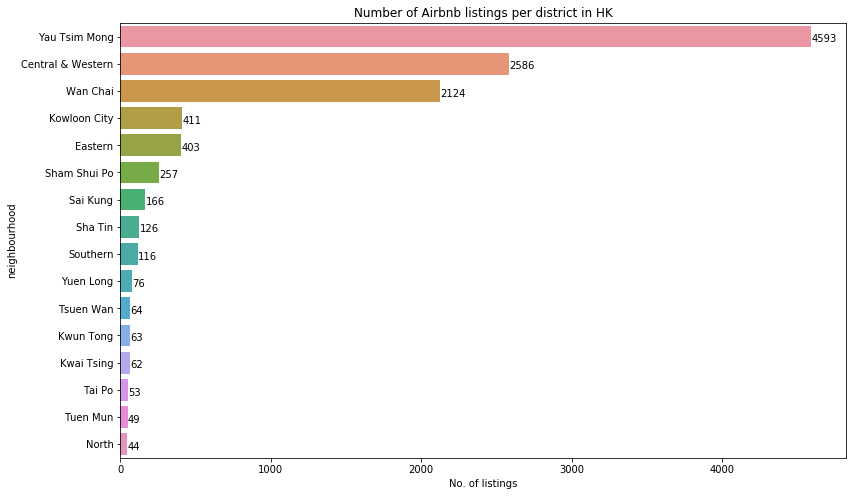

In [82]:
nbh_listing_count.sort_values("listing_count", ascending=False, inplace=True)
nbh_listing_count = nbh_listing_count[:16]

f, ax = plt.subplots(figsize=(13, 8))

sns.barplot(data=nbh_listing_count, x = 'listing_count', y = 'neighbourhood')

ax.set_title("Number of Airbnb listings per district in HK")
ax.set_xlabel('No. of listings')

for p in ax.patches:
    width = p.get_width()
    ax.text(width,
            p.get_y()+p.get_height()/2 + 0.2,
            '{:1.0f}'.format(width),
            ha="left")

Out of 11216 Airbnb listings, it is clear to see that most of them were located in Yau Tsim Wong District (4593), Central & Western District (2586) and Wan Chai District (2124), followed by Kowloon City District (411) and Eastern District (403). Although below map was captured from InsideAirbnb website on 20-Dec 2019, we can see the same result too.

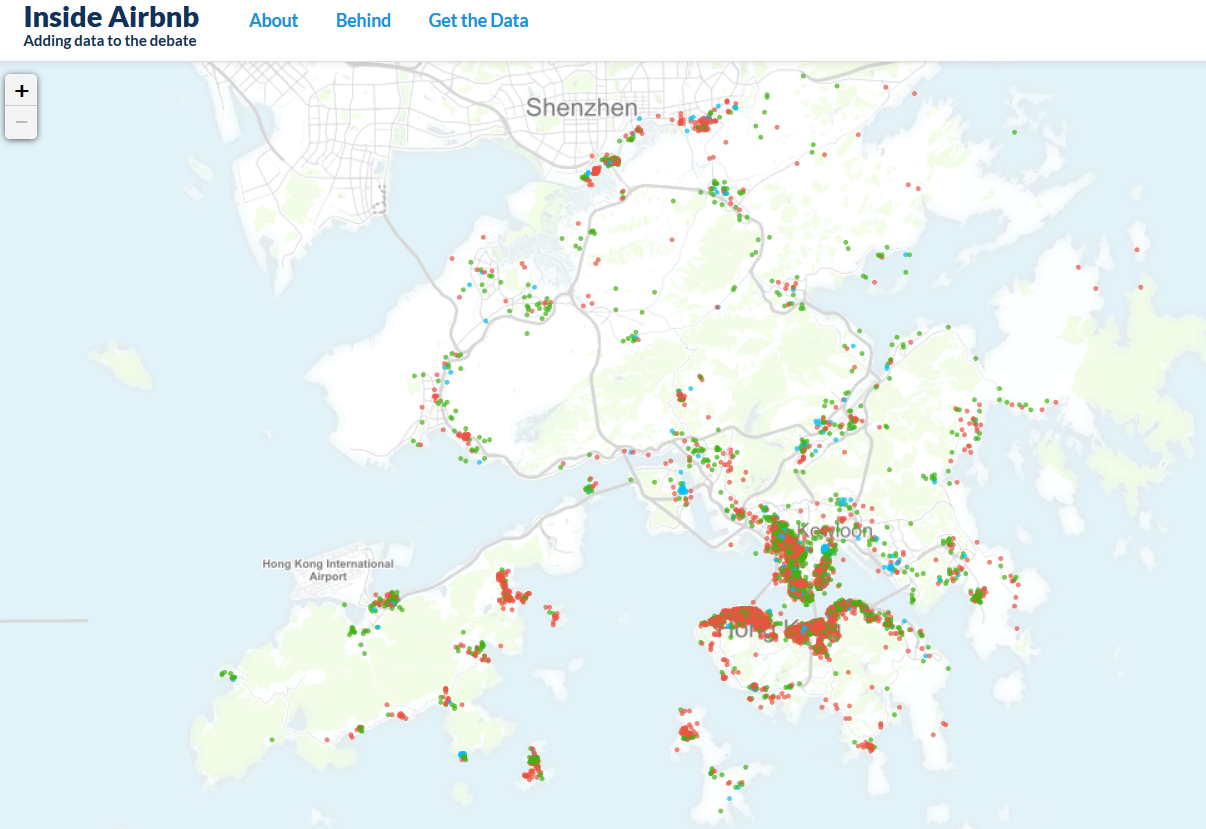

In [83]:
from IPython.display import Image
Image(filename ="snapshot from InsideAirbnb (191220).PNG", width=600, height=600)

### General description of nightly advertised price

Bear in mind that the variable 'price' refers the nightly advertised price rather than the actual amount which have been paid by previous guests. The advertised prices only reflect the arbitrary amount set by the host.

A more accurate version of price per night should be collected from companies like AirDNA that sell higher quality Airbnb data.

In [84]:
print('Nightly advertised prices range from HK${} to HK${}.'.format(int(min(listings_final['price'])), int(max(listings_final['price']))))
print('Median price per night: HK${}'.format(int(statistics.median(listings_final['price']))))
print('Average rental per night: HK${}'.format(int(statistics.mean(listings_final['price']))))

Nightly advertised prices range from HK$47 to HK$155517.
Median price per night: HK$533
Average rental per night: HK$855


### Plotting Histogram of nightly advertised price

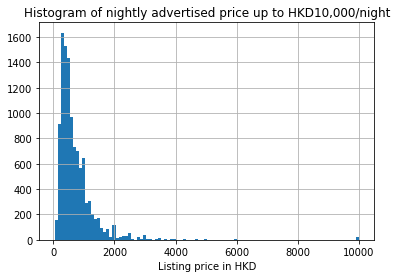

In [85]:
#Remove outliers (n=59) with price over $10000/night
listings_final.loc[(listings_final.price < 10000)].price.hist(bins=100)
plt.xlabel('Listing price in HKD')
plt.title('Histogram of nightly advertised price up to HKD10,000/night');

After removing 59 outliers with price over HK\\$10,000 per night, we can see that most listing prices were below HK\\$2,000 per night. (p.s. the most expensive rental price per night is HK\\$155,517, unbelievable)

### Listing price vs. Number of beds

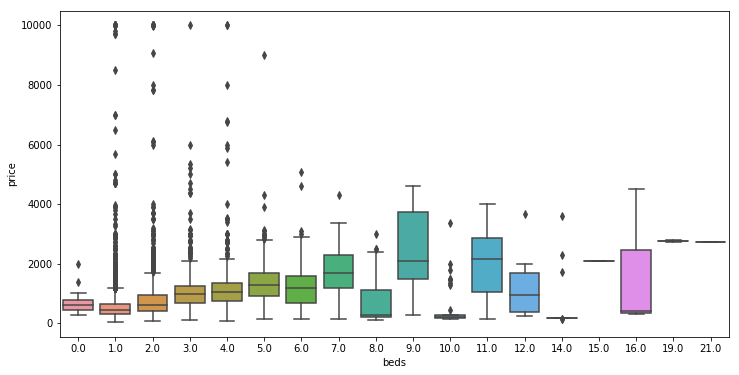

In [86]:
plt.figure(figsize=(12,6))

sns.boxplot(y='price', x='beds', data = listings_final.loc[(listings_final['price'] <= 10000)])
plt.show();

It is interesting to see that the some listings do not provide any beds, but the median price was even higher than listing with 1-bed.

### Exploring Room Type

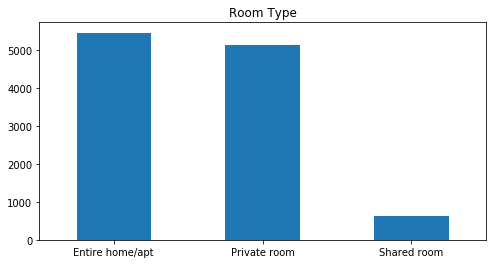

Entire home/apt    0.486626
Private room       0.457561
Shared room        0.055813
Name: room_type, dtype: float64


In [87]:
plt.figure(figsize=(8,4))
listings_final['room_type'].value_counts().plot(kind='bar')
plt.title('Room Type')
plt.xticks(rotation=0)
plt.show()

print(listings_final['room_type'].value_counts(normalize=True))

About half of listings were 'Entire homes/apartment', whereas 46% were 'Private rooms' (e.g. renting a bedroom with a bathroom only in the property). Less than 6% were 'Shared rooms' (e.g. sharing a room with other guests).

### Exploring Review Scores

In [88]:
def review_count_plot(col, figsize=(8,5)):
    """
    Use seaborn library to plot a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """ 
    sns.set(style="darkgrid")

    result = listings_final[col].value_counts().sort_index(ascending=True)
    
    ax = sns.countplot(x=col, data=listings_final, order=result.index)

    plt.title(col, fontsize=13)
    plt.xlabel('score')
    plt.ylabel('')

    total = len(listings_final[col])

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 50,
                '{:1.0f}%'.format(height/total*100),
                ha="center") 

    plt.show()

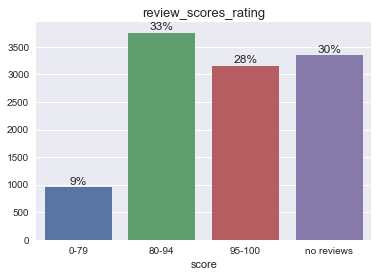

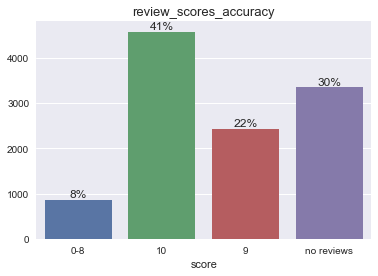

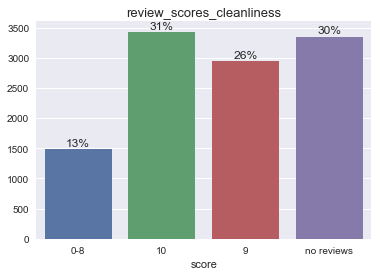

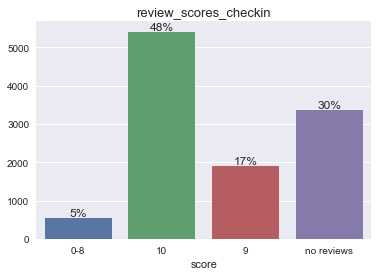

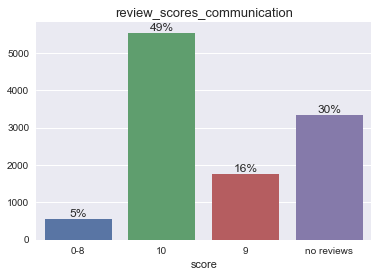

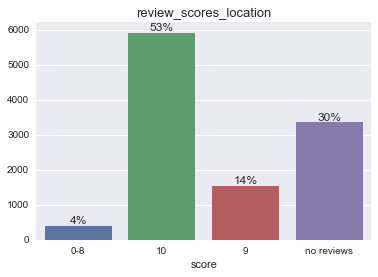

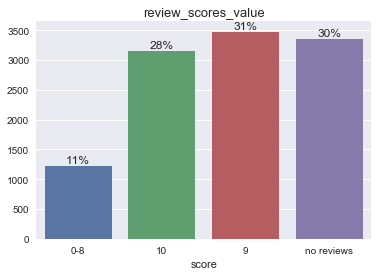

In [89]:
list_review_col = list(listings_final.columns[listings_final.columns.str.startswith("review_scores") == True])
                       
for col in list_review_col:
    review_count_plot(col)

About 61% of listings had received overall rating score over 80, with 28% had received score 95 or above.

30% of listings, however, had not yet been reviewed.

For each review subcategory (incl. rating, accuracy, cleaniness, check-in, communication, location) except "value", rating of 10 (full score) shared the largest portion among others, whereas ratings of 0-8 were rare. Guests seem to be most satisfied about location, check-ins and communication, but more conservative to rate high score in 'value'. The most common reason is that the outcomes of Airbnb experience are not what they expect to pay for.

### First review & Last reviews

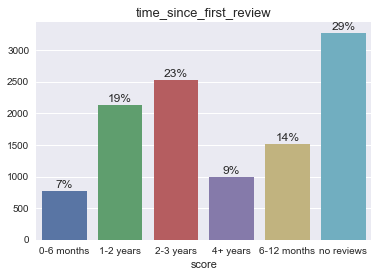

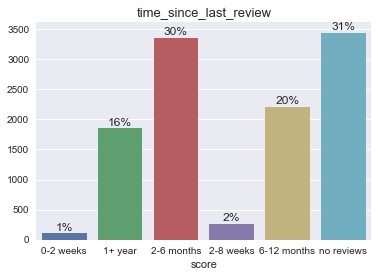

In [90]:
for col in ['time_since_first_review', 'time_since_last_review']:
    review_count_plot(col)

The most common time period in which current Airbnb listings had their first review is 2-3 years. Relatively few have been active for less than 6 months, however.

The most common category for the time since a listing received its last review is 2-6 months. That means a lot of listings have received review recently. The majority of these are probably what are sometimes referred to 'active' listings.  However, there are still around 1.8K listings which have not had a review for more than a year. The majority of these are probably what are sometimes referred to 'inactive' listings, because they are technically live on the site but not available for booking.

As mentioned, about 30% of listings had not yet been reviewed.

### Listings price vs. Districts

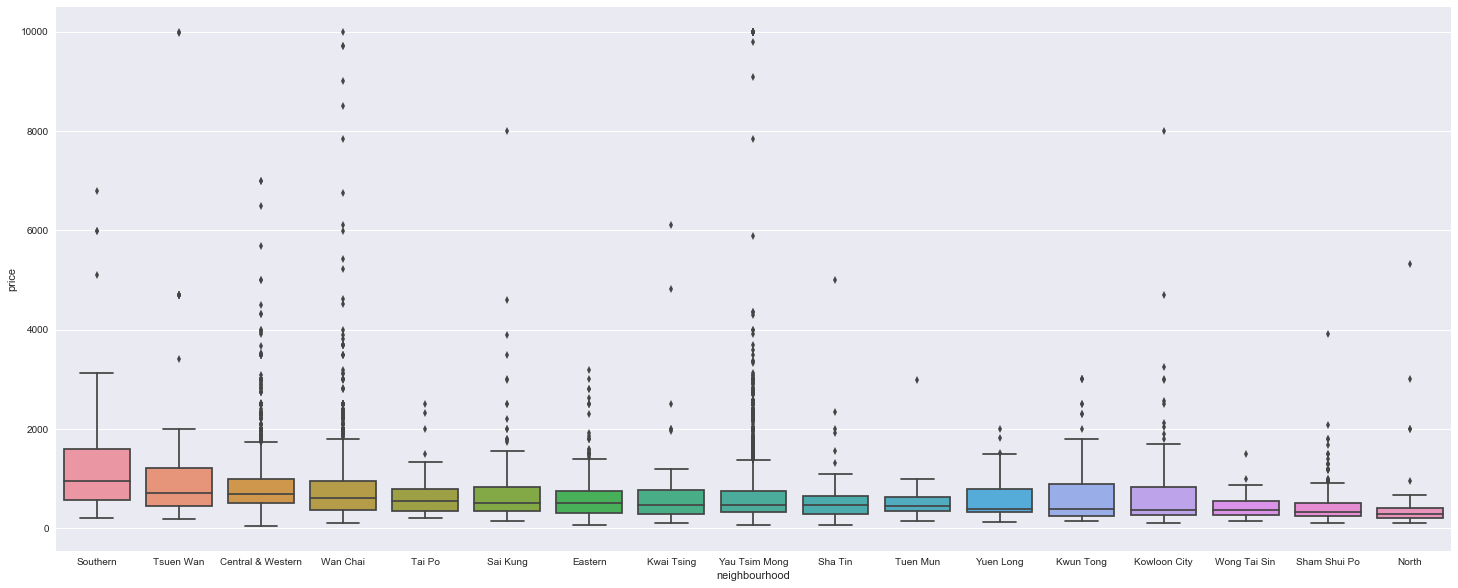

In [91]:
plt.figure(figsize=(25,10))

#Remove outliers (n=59) with price over $10000/night and sort by median price
sorted_median_p = listings_final.loc[(listings_final.price < 10000)].groupby('neighbourhood')['price'].median().sort_values(ascending=False).index

sns.boxplot(y='price', x='neighbourhood', data=listings_final.loc[(listings_final.price < 10000)], order=sorted_median_p);

District with the highest and lowest median price is Southern District (HK\\$960.5) and North District (HK\\$298) respectively. North District also has the fewest number of listings, but Southern District includes 116 listings only.

### Evaluate relationship between Listing's proximity to MTR station and popular Local Venues

In [92]:
#calculate Pearson's correlation
x_array = np.array(listings_final['distance_to_the_nearest_station_KM'])
y_array = np.array(listings_final['avg_walking_mins_to_top5_neighhourhood_venues'])

corr, _ = pearsonr(x_array, y_array)
print('Pearsons correlation: %.2f' % corr)

Pearsons correlation: 0.40


It is not surprising that two location features are positively correlated and that the correlation is 0.40, implying the apartment closer to the popular venues in the district is often closer to the MTR station.

In [93]:
#calculate Pearson's correlation
x_array = np.array(listings_final['avg_walking_mins_to_top5_neighhourhood_venues'])
y_array = np.array(listings_final['price'])

corr, _ = pearsonr(x_array, y_array)
print('Pearsons correlation: %.2f' % corr)

Pearsons correlation: -0.01


The listing price, however, do not have significant correlations with proximity to popular venues in the district.

### How price changes over the year by month?

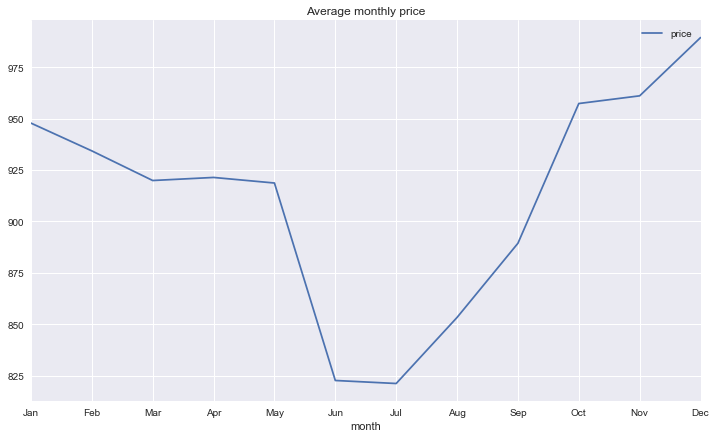

In [94]:
#create month index dict for mapping
month_index_mapping = {v: k for k,v in enumerate(calendar.month_abbr)}

#create new column for month and month index
#'%b' => use the abbriviation of month
calendar_df['month'] = calendar_df['date'].dt.strftime('%b')
calendar_df["month_index"] = calendar_df['month'].map(lambda x: month_index_mapping[x])

#group by month and month index
mean_of_month = calendar_df.groupby([calendar_df['month'],calendar_df['month_index']])['price'].mean().reset_index()

#sort by month index
mean_of_month.sort_values('month_index', inplace=True)
mean_of_month = mean_of_month.reset_index(drop=True)

#set 'month' as index
mean_of_month.set_index('month',inplace=True)

#drop 'month_index' column
mean_of_month.drop('month_index', axis=1, inplace=True)

#Plot Bar Chart
mean_of_month.plot(kind = 'line', figsize = (12,7))

#customize xlabel text and title
plt.xticks(np.arange(12), calendar.month_abbr[1:13])
plt.title('Average monthly price');

The Airbnb average price in Hong Kong fell sharpyly in June and July, then bounced back in the coming months until December. In hindsight, presumably such price cut during summer vacation is due to fierce competition, whereas strong demand for short-stay lodging during the holiday season stimulated surging price before December.

Let's further check if any seasonality pattern is found from the figures of new-joined Airbnb hosts.

### Seasonality of new hosts joining Airbnb?

A given time series consists of three systematic components (i.e. can be modeled) including level, trend, seasonality, and one non-systematic component (i.e. cannot be modeled) called noise/residual.

In [95]:
#Time-series analyis coding reference: https://github.com/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb

#Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings_final.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings_final.set_index('first_review').resample('MS').size())

#Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [96]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

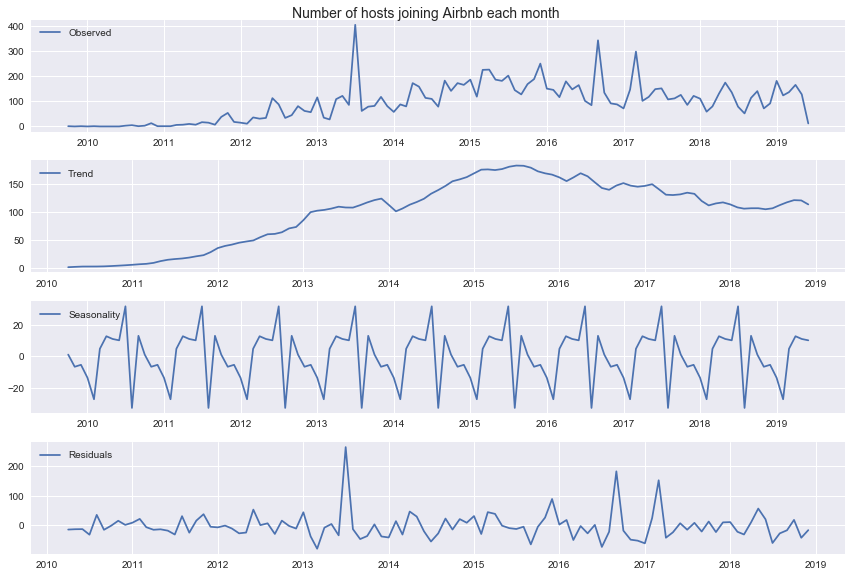

In [97]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

The seasonality pattern was evident: number of new hosts reached the peak level before summer holiday, followed by a steep fall during July and August. The pattern repeated within a given year, every year.

The above finding implies that many new hosts had joined before summer holiday and offer competitive pricing during the time.

### Commerical operation running by Airbnb host?

Some may argue that the so-called Airbnb 'sharing economy' is actually commercial operations rather than individuals renting a spare room or apartment by Airbnb host. Let's check whether this allegation is valid or not.

In [98]:
print(f"{int(round(100*len(listings_final[listings_final.host_listings_count >= 5])/len(listings_final)))}% of listings were from hosts with at least 5 listings.")
print(f"{int(round(100*len(listings_final[listings_final.host_listings_count == 1])/len(listings_final)))}% of listings were from hosts with one listing only.")

51% of listings were from hosts with at least 5 listings.
30% of listings were from hosts with one listing only.


In [99]:
# List of the top 5 host with the most number of listings on Airbnb
listings_final.sort_values('host_listings_count').drop_duplicates('host_id')[['host_id', 'host_since', 'host_listings_count']].reset_index(drop=True).tail()

,host_id,host_since,host_listings_count
4911,138649185,2017-07-05,145.0
4912,122131447,2017-03-23,147.0
4913,156409670,2017-10-27,150.0
4914,97240131,2016-09-29,219.0
4915,7518056,2013-07-16,343.0


It is undeniable to say that many hosts are hosting a large number of listings under single identity. Based on our cleansed dataset (n=11216), 51% of Airbnb listings in Hong Kong belonged to hosts renting at least 5 rooms or apartments, and only 30% of listings were from hosts renting one room or apartment only. For example, 'Jovee', the largest host who had joined Airbnb since Jul-2013, had managed 343 listings under the name 'Jovee', while the second largest is called 'Jov', managing 219 listings. From their host name, it casts doubt on same identity association.

As almost half of listings were from hosts renting with at least 5 properties, we can conclude that these are commercial operations rather than individuals renting a spare room.

# (8) Final step before modeling: Removing features with Multicollinearity features and rescaling variables

Multicollinearity exists when at least some of the dependent variables are correlated among themselves. As a result, it makes us difficult to ascertain importantance of of features to the target variable and affect model's performance. Removing multicollinearity can also make the model less complex for generalization purpose. Therefore, it is important to run multicollinearity detection before building regression model.

### Drop the variables that we no longer need for modeling

In [100]:
#set id as index
listings_final.set_index('id', inplace=True) # ID as index

# Dropping variables no longer needed
listings_final.drop(['latitude', 'longitude', 'host_id', 'host_since','amenities',
                     'nearest_mtr_station', 'walking_mins_to_the_nearest_station',
                     'first_review', 'avg_walking_mins_to_top5_neighhourhood_venues'], axis=1, inplace=True)

In [101]:
#One Hot Encoding (converting to dummy variable) for categorical variables
listings_final = pd.get_dummies(listings_final)
listings_final.head()

,host_listings_count,distance_to_the_nearest_station_KM,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_no reviews,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,time_since_last_review_no reviews
id,,,,,,,,,,,,,,,,,,,,,
69074,2.0,0.5,3,1.0,1.0,2.0,1412.0,2353.0,314.0,2,...,0,1,0,0,0,0,0,0,1,0
103760,12.0,0.4,6,1.0,2.0,3.0,855.0,784.0,306.0,2,...,0,1,0,0,0,0,0,0,1,0
132773,12.0,0.1,6,1.0,2.0,3.0,1059.0,784.0,306.0,3,...,0,1,0,0,0,0,1,0,0,0
133390,1.0,0.4,2,1.0,1.0,1.0,941.0,1176.0,0.0,1,...,0,1,0,0,0,1,0,0,0,0
163214,0.0,0.2,2,1.0,1.0,1.0,1051.0,1000.0,160.0,1,...,0,0,0,1,0,0,0,0,0,1


### Identify Highly Correlated Features from correlation matrix

The correlation coefficient has values between -1 to 1. The value closer to 1/-1 implies stronger correlation, or vice versa.

We will identify highly correlated features with absolute correlation value 0.5 or above first. If these variables are highly correlated with each other, then we only need to keep only one of them and drop the rest.

In [102]:
#Create correlation matrix
corr_matrix = listings_final.corr().abs()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#Find index of feature columns with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

print(to_drop)

['bedrooms', 'beds', 'guests_included', 'availability_60', 'availability_90', 'availability_365', 'price_per_person', 'Essentials', 'Microwave', 'Dishes and silverware', 'Refrigerator', 'Smoke detector', 'Fire extinguisher', 'Cooking basics', 'Bed linens', 'Luggage dropoff allowed', 'host_response_time_unknown', 'host_response_time_within an hour', 'host_response_rate_0-49%', 'host_response_rate_100%', 'host_response_rate_90-99%', 'host_response_rate_unknown', 'host_is_superhost_1', 'host_identity_verified_1', 'neighbourhood_Sai Kung', 'is_location_exact_1', 'property_type_Other', 'room_type_Private room', 'bed_type_Real Bed', 'instant_bookable_1', 'review_scores_accuracy_0-8', 'review_scores_accuracy_10', 'review_scores_accuracy_9', 'review_scores_accuracy_no reviews', 'review_scores_cleanliness_0-8', 'review_scores_cleanliness_10', 'review_scores_cleanliness_9', 'review_scores_cleanliness_no reviews', 'review_scores_checkin_0-8', 'review_scores_checkin_10', 'review_scores_checkin_no 

In [103]:
#Inspect highly correlated variables
high_corr_var = ['accommodates','availability_30','price_per_person',
                 'Smoke detector','host_response_time_unknown','host_response_time_a few days or more',
                 'host_response_time_within an hour']

#Correlation with output variable
for var in high_corr_var:
    cor_target = abs(listings_final.corr()[var])

    #Select highly correlated features related to the selected variable
    relevant_features = cor_target[cor_target>0.5]
    print(relevant_features) 
    print('---------------')

accommodates       1.000000
bedrooms           0.566149
beds               0.752463
guests_included    0.571989
Name: accommodates, dtype: float64
---------------
availability_30     1.000000
availability_60     0.955251
availability_90     0.913599
availability_365    0.635717
Name: availability_30, dtype: float64
---------------
price               0.782096
price_per_person    1.000000
Name: price_per_person, dtype: float64
---------------
Carbon monoxide detector    0.513446
Smoke detector              1.000000
Fire extinguisher           0.586488
Name: Smoke detector, dtype: float64
---------------
availability_60                      0.510595
availability_90                      0.534759
host_response_time_unknown           1.000000
host_response_time_within an hour    0.545837
host_response_rate_100%              0.541753
host_response_rate_unknown           1.000000
Name: host_response_time_unknown, dtype: float64
---------------
host_response_time_a few days or more    1.000000

### Summary of multi-collinearity:

(1) 'Beds', 'bedrooms', 'guests_included' are highly correlated with 'accommodates' (number of guests accommodated).

    Number of people accommodated has traditionally been a more high priority search parameter on Airbnb, followed by room details such as number of beds and bedrooms. Therefore, we will only keep 'accomodates' while others will be dropped for modeling.

(2) Unsurprisingly, the four 'availability' variables are highly related to each other. 

    For example, we can see that there is a fairly strong correlation (0.96) between 'availability_30' and 'availability_60'. This is a strong sign of multicollinearity. Therefore, we will only keep 'availability_30' while others will be dropped.
 
(3) 'Stove', 'Dishes and silverware' and 'Microwave' are highly correlated with 'Cooking basics'.

    It shows that kitchenware available in the listings are highly correlated with each other. Therefore, we will only keep 'Cooking basics' as it is the main category of kitchenware.
    
(4) 'Bed linens' is highly correlated with 'Extra pillows and blankets'. 

    The latter one will be dropped.
    
(5) There is fairly strong correlation between 'host_response_time_a few days or more' and 'host_response_rate_0-49%'. The similar correlation is found between 'host_response_time_within an hour' and 'host_response_rate_100%'.             

     Although these are important categories, one of each (i.e. 'host_response_time_a few days or more' and 'host_response_time_within an hour') will be dropped in order to reduce multi-collinearity.
     
(6) Meanwhile, 'host_response_time_unknown' is perfectly correlated with 'host_response_rate_unknown'.

    If no one had ever asked hosts any questions, then both variable values should be unknown. Therefore, one of them will be dropped. 
     
(6) There are strong correlations between 'property_type_Apartment' and 'property_type_Others', and between 'room_type_Private room' and 'room_type_Entire_home_apt'.

     Although these are important categories, one of each (i.e. 'property_type_Others' and 'room_type_Private room') will be dropped in order to reduce multi-collinearity.
    
(7) There are perfect correlations between no reviews (i.e. listings that are not reviewed yet) subcategories, and first and last review times. 

    These 'no review' variables can be dropped altogether.

(8) Boolean variable (e.g. 'instant_bookable_0' vs. 'instant_bookable_1') is highly correlated with each other for the same feature.
    
    One of them for each feature will be dropped.

In [104]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'availability_60',
           'availability_90',
           'availability_365',
           'Stove',
           'Dishes and silverware',
           'Microwave',
           'Stove',
           'Dishes and silverware',
           'Microwave',
           'Extra pillows and blankets',
           'host_is_superhost_1',
           'host_identity_verified_1',
           'is_location_exact_1',
           'instant_bookable_1',
           'host_response_time_unknown',
           'host_response_time_a few days or more',
           'host_response_time_within an hour',
           'property_type_Other',
           'room_type_Private room'
          ]
to_drop.extend(list(listings_final.columns[listings_final.columns.str.endswith('no reviews')]))

listings_final.drop(to_drop, axis=1, inplace=True)

### Final assessment of multi-collinearity using correlation matrix heatmap

In [105]:
def multi_collinearity_heatmap(df, figsize=(30,30)):
    
    """
    Creates a heatmap of correlations between features.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(200, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

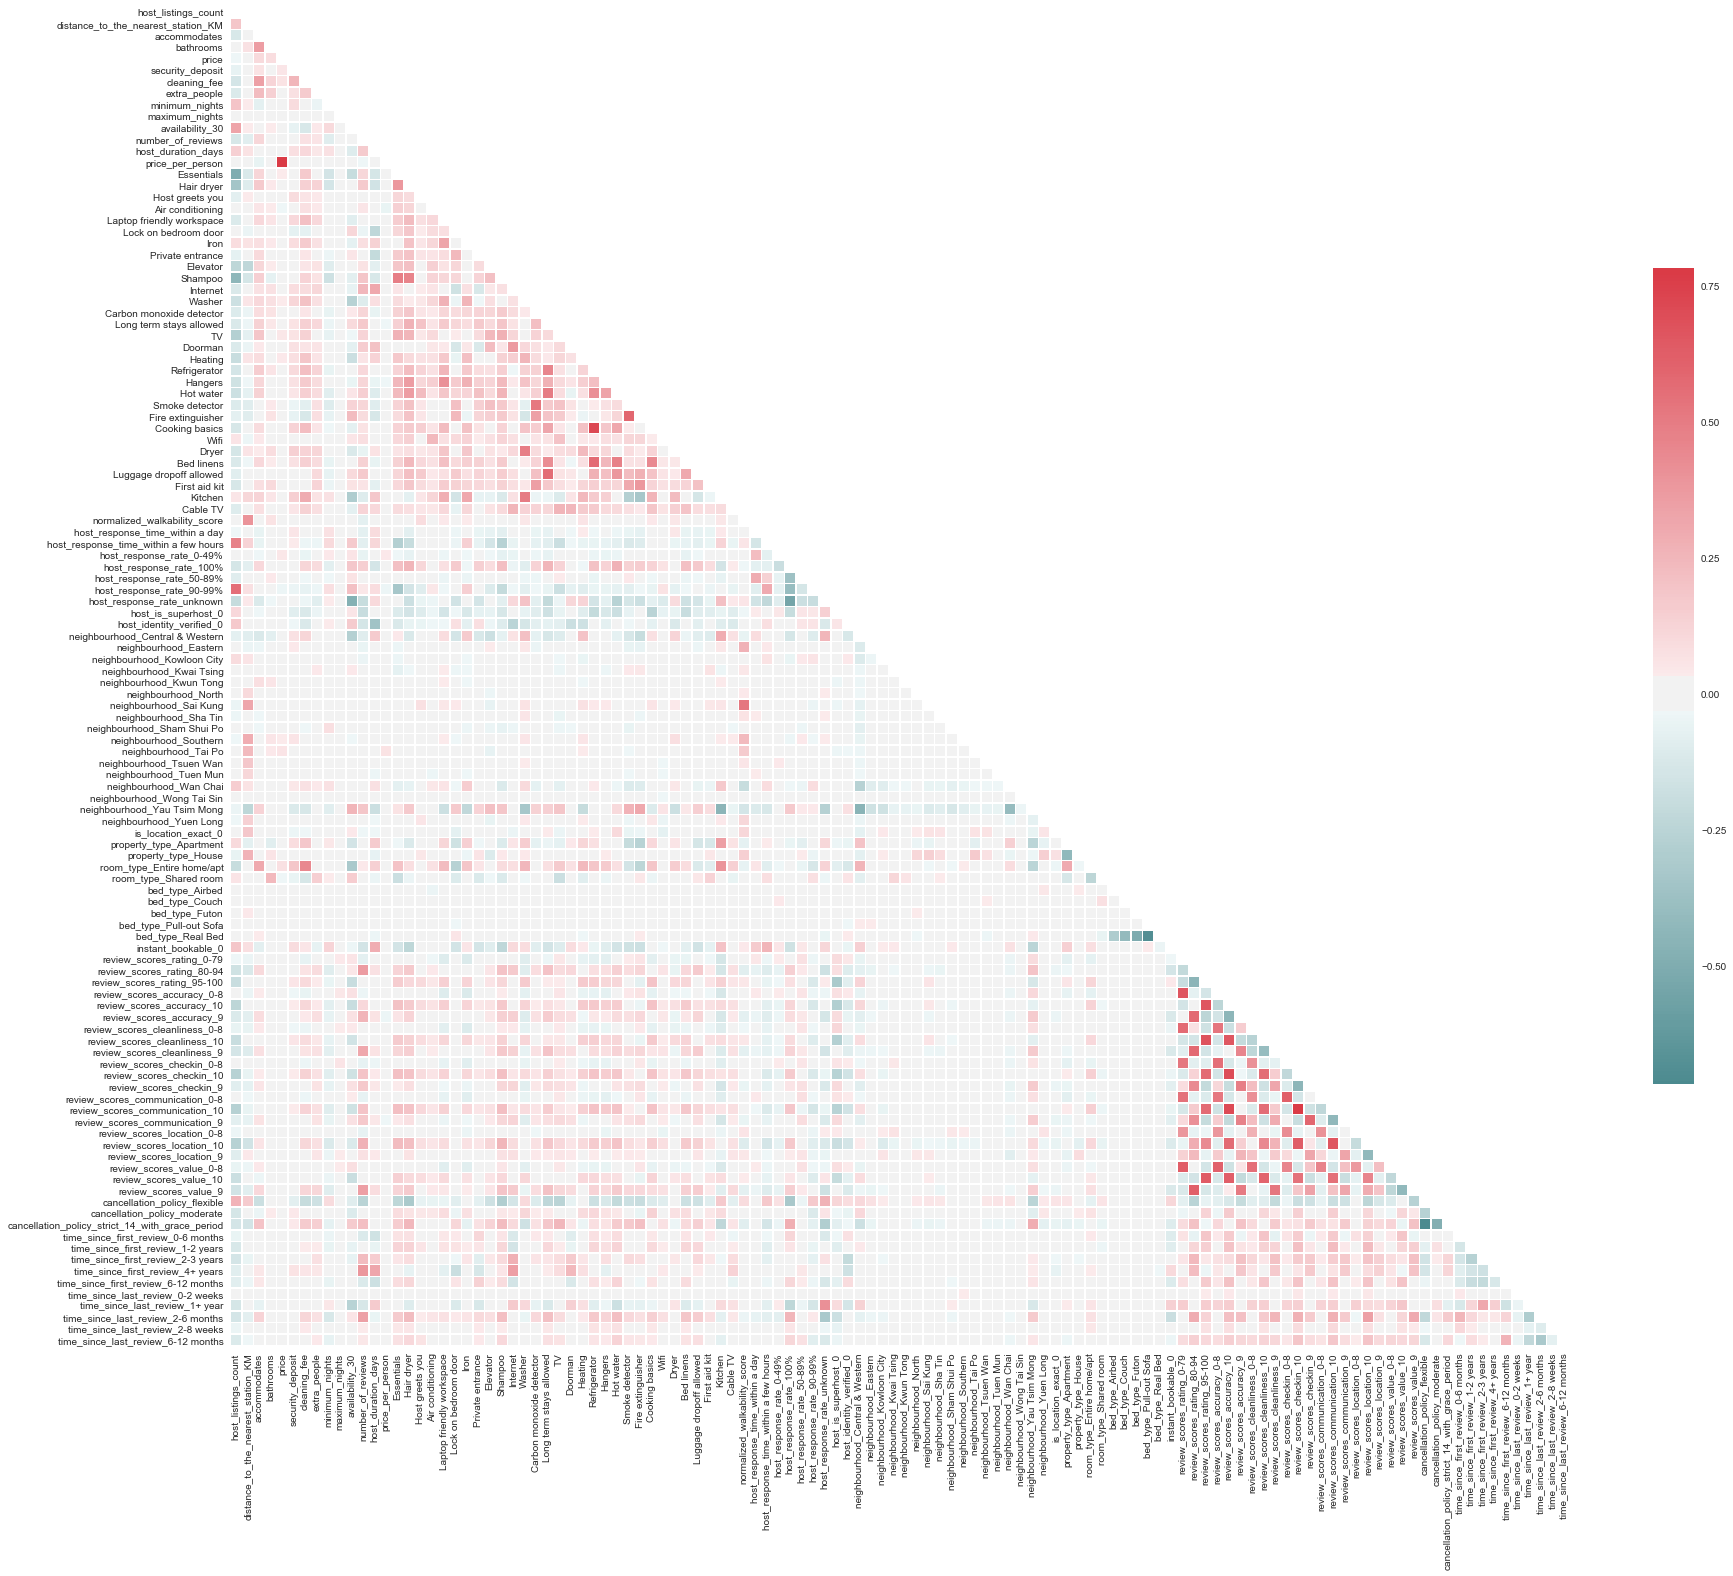

In [106]:
multi_collinearity_heatmap(listings_final)

From the above heatmap, we can still see:

(1) 'price' is obviously highly correlated with 'price_per_person'.

    The latter one will be dropped.

(2) 'Cooking basics' is still highly correlated with 'Refrigerator'.

    The latter one will be dropped.
    
(3) a highly correlation 'cancellation_policy_flexible' and 'cancellation_policy_strict_14_with_grace_period'.

    Again, the latter one will be dropped.

(4) a highly correlation between 'Luggage dropoff allowed' and 'Long term stays allowed'.
    
    Apartment available for long term stay usually allow guest to drop off luggage. Again, the latter one will be dropped.
    
(5) There are still fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets score 9-10 score for overall rating, it is likely to score 9-10 for other review categories. 
    
    However, these will be left in for now and can be experimented with later to see if removing them improves the model.

In [107]:
# Dropping collinear features
to_drop_further = ['price_per_person',
                   'Refrigerator',
                   'cancellation_policy_strict_14_with_grace_period',
                   'Long term stays allowed'
                  ]

listings_final.drop(to_drop_further, axis=1, inplace=True)

### Test of skewness and kurtosis

Skewness is used to describe the degree of asymmetry of data. If the input data is too deviate from (Gaussian) distribution, it will seriously affect model performance such as linear regression and reduce the models from varying widely.

Kurtosis is a statistical measure used to describe the "tailedness" of the probability distribution. If the kurtosis is above zero, the distribution has a marked peak. If it is below zero, the distribution is too flat instead.

When performing the skewness and kurtosis tests, if p-value is less than 0.05, it implies normality assumption is rejected and we could obtain better results after feature scaling. In our study, log transformation and standardization method will be used to perform scaling transformation of the interval variables.

Skewness score: 

host_listings_count:      skewness 3.504  z-score 76.458  p-value 0.000
distance_to_the_nearest_station_KM:      skewness 5.383  z-score 91.369  p-value 0.000
accommodates:      skewness 2.461  z-score 64.420  p-value 0.000
bathrooms:      skewness 6.097  z-score 95.727  p-value 0.000
price:      skewness 30.783  z-score 152.830  p-value 0.000
security_deposit:      skewness 9.053  z-score 109.618  p-value 0.000
cleaning_fee:      skewness 3.872  z-score 79.898  p-value 0.000
extra_people:      skewness 5.138  z-score 89.742  p-value 0.000
minimum_nights:      skewness 21.357  z-score 139.910  p-value 0.000
maximum_nights:      skewness 74.864  z-score 184.251  p-value 0.000
availability_30:      skewness -0.051  z-score -2.204  p-value 0.028
number_of_reviews:      skewness 3.553  z-score 76.935  p-value 0.000
host_duration_days:      skewness 0.105  z-score 4.534  p-value 0.000
normalized_walkability_score:      skewness 4.842  z-score 87.668  p-value 0.000
--------

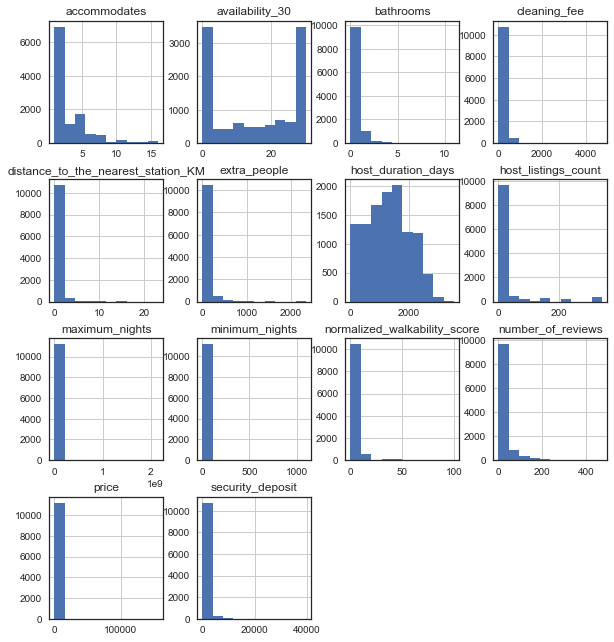

In [108]:
interval_var = ['host_listings_count','distance_to_the_nearest_station_KM','accommodates',
                'bathrooms','price','security_deposit','cleaning_fee','extra_people',
                'minimum_nights','maximum_nights','availability_30','number_of_reviews',
                'host_duration_days','normalized_walkability_score']

#visualizing distribution of interval variable
listings_final[interval_var].hist(figsize=(10,11));

#test skewnwss
print('Skewness score: \n')
for var in interval_var:
    s = skew(listings_final[var])
    zscore, pvalue = skewtest(listings_final[var])
    print('{}:      skewness %0.3f  z-score %0.3f  p-value %0.3f'.format(var) % (s, zscore, pvalue))

#test kurtosis
print('------------------')
print('Kurtosis score: \n')
for var in interval_var:
    k = kurtosis(listings_final[var])
    zscore, pvalue = kurtosistest(listings_final[var])
    print('{}:      kurtosis %0.3f  z-score %0.3f  p-value %0.3f'.format(var) % (k, zscore, pvalue))

### Log Transformation

Other than 'availability_30' and 'host_duration_days', the remaining numerical features are all postively skewed and could benefit from log transformation.

In [109]:
#Log transforming columns
for col in interval_var:
    listings_final[col] = np.log(listings_final[col] + 1)

### Standardization

Then we applied ‘Standardization’ to rescale the values so that the distribution standard deviation from the mean equals one. As such, each variable can be treated equally in the model.

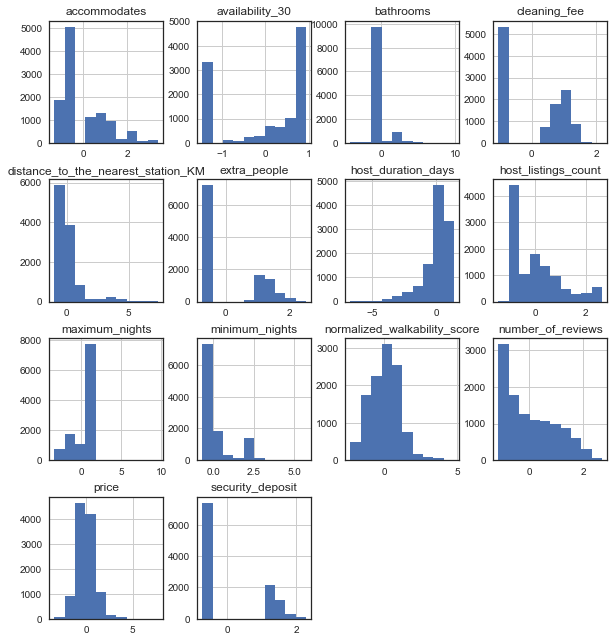

In [110]:
#Convert non-categorical variables to floats and standardize
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)

for col in interval_var:
    listings_final[col] = listings_final[col].astype('float')
    listings_final[col] = standardize_col(listings_final[col])
    
listings_final[interval_var].hist(figsize=(10,11));

In [111]:
#Export cleansed listings datasets
listings_final.to_csv('listings(cleansed)' + '.csv', index = False)

# (9) Modeling

In [112]:
#Separating X and y
X = listings_final.drop(['price'], axis=1)
y = listings_final['price']

#Split into train and test sets (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Run a linear regression as our base model

In [113]:
#Add a constant
X_train = sm.add_constant(X_train)

#Fit model to the train set
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train) 

#print model summary
model.summary()

C:\Users\komin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     74.82
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        00:51:52   Log-Likelihood:                -9767.2
No. Observations:                8972   AIC:                         1.975e+04
Df Residuals:                    8863   BIC:                         2.053e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.2480      0.081     -3.059      0.002      -0.407      -0.089
host_listings_count                      -0.0794      0.013     -6.247      0.000      -0.104      -0.055
distance_to_the_nearest_station_KM        0.0314      0.011      2.964      0.003       0.011       0.052
accommodates                              0.3245      0.010     31.412      0.000       0.304       0.345
bathrooms                                 0.0572      0.009      6.617      0.000       0.040       0.074
security_deposit                          0.0379      0.009      4.040      0.000       0.020       0.056
cleaning_fee                             -0.0042      0.010     -0.405      0.686      -0.025       0.016
extra_people                             -0.0635      0.009     -6.840      0.000      -0.082      -0.045
minimum_nights                           -0.0857      0.010     -8.162      0.000      -0.106      -0.065
maximum_nights                            0.0108      0.008      1.334      0.182      -0.005       0.027
availability_30                           0.0685      0.010      6.567      0.000       0.048       0.089
number_of_reviews                        -0.1080      0.019     -5.763      0.000      -0.145      -0.071
host_duration_days                        0.0312      0.010      3.241      0.001       0.012       0.050
Essentials                                0.0583      0.029      2.019      0.044       0.002       0.115
Hair dryer                                0.0107      0.023      0.466      0.641      -0.034       0.056
Host greets you                           0.1286      0.025      5.182      0.000       0.080       0.177
Air conditioning                         -0.2212      0.052     -4.262      0.000      -0.323      -0.119
Laptop friendly workspace                 0.0113      0.019      0.603      0.547      -0.025       0.048
Lock on bedroom door                     -0.0107      0.018     -0.583      0.560      -0.047       0.025
Iron                                      0.0491      0.019      2.629      0.009       0.012       0.086
Private entrance                          0.0391      0.020      1.970      0.049       0.000       0.078
Elevator                                  0.0506      0.020      2.526      0.012       0.011       0.090
Shampoo                                   0.0897      0.025      3.593      0.000       0.041       0.139
Internet                                  0.0405      0.024      1.683      0.092      -0.007       0.088
Washer                                    0.0032      0.021      0.150      0.880      -0.038       0.044
Carbon monoxide detector                 -0.0005      0.025     -0.020      0.984      -0.050       0.049
TV       

### Calculate VIF for each feature

In our study, Variance Inflation Factor (VIF) method is used to estimate the severity of multicollinearity within the context of a regression. The rule of thumb threshold is VIF at the level of 5, meaning if the VIF is above 5 we should consider there is effect of multicollinearity on the fitted model.

Therefore, the dependent variables having VIF value above 5 will be removed.

In [ ]:
#Calculate VIF for each feature, then save to its own DF
vif_census = pd.DataFrame()
vif_census['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_census['features'] = X.columns

C:\Users\komin\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
vif.round(1)